In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model, load_model
import tensorflow_io as tfio
from tensorflow.io import decode_jpeg
AUTO = tf.data.AUTOTUNE
import os
import random

from keras.utils import save_img

import glob
import numpy as np
import pandas as pd

from sklearn import preprocessing


import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tifffile as tiff


from tqdm import tqdm
import wandb
wandb.login()

decode_tiff = tfio.experimental.image.decode_tiff

TARGET_WIDTH = 1024

IMAGES_PER_SHARD = 10
OUTPUT_NAME_PREFIX = "tissues_"

class config:
    train_path = "./"
    
    #wandb config
    WANDB_CONFIG = {
        "competition": "HuBMAP",
        "_wandb_kernel": "neuracort"
    }
    run = wandb.init(project="humap_AA", entity="giru", config=WANDB_CONFIG)



wandb: Currently logged in as: giru. Use `wandb login --relogin` to force relogin


In [2]:
df = pd.read_csv("train.csv")

df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [3]:
%%capture
wandb.log({"df_train": df})

(3000, 3000, 3)


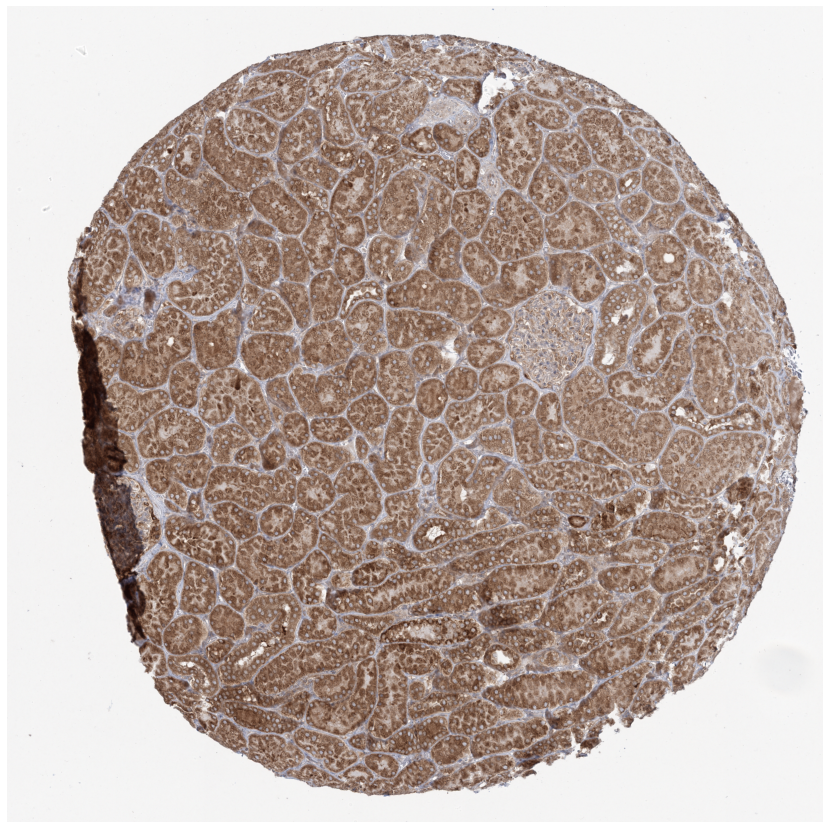

In [3]:
img_id_1 = 9445
img_1 = tiff.imread(config.train_path + "train_images/"+ str(img_id_1)+ ".tiff")
print(img_1.shape)

plt.figure(figsize=(15, 15))
plt.imshow(img_1)
plt.axis("off")
wandb.log({"Image Sample 1": plt})

<h1>MASK</h1>

In [4]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
mask_1 = rle2mask(df[df["id"]==img_id_1]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
print(mask_1.shape)

(3000, 3000)


In [6]:
print(df[df["id"]==img_id_1]["rle"].iloc[-1])

5515207 20 5518204 29 5521202 35 5524202 36 5527201 37 5530198 87 5533197 90 5536196 92 5539194 97 5542193 100 5545191 103 5548190 105 5551189 107 5554189 108 5557187 111 5560181 118 5563179 121 5566178 123 5569177 124 5572175 127 5575173 129 5578172 131 5581170 133 5584164 141 5587162 144 5590158 148 5593155 152 5596153 154 5599126 182 5602125 183 5605117 192 5608115 195 5611113 198 5614111 200 5617110 202 5620110 202 5623109 204 5626107 206 5629106 208 5632105 209 5635104 211 5638104 212 5641103 213 5644102 215 5647100 217 5650099 219 5653098 220 5656098 221 5659097 224 5662097 225 5665096 226 5668096 227 5671095 228 5674095 230 5677094 232 5680093 233 5683093 234 5686092 235 5689091 236 5692091 236 5695090 237 5698088 240 5701087 241 5704087 242 5707087 272 5710086 278 5713086 279 5716085 281 5719084 283 5722083 285 5725083 286 5728082 287 5731082 287 5734082 287 5737082 287 5740081 288 5743081 288 5746080 290 5749079 291 5752078 292 5755078 292 5758078 292 5761078 292 5764077 294 5

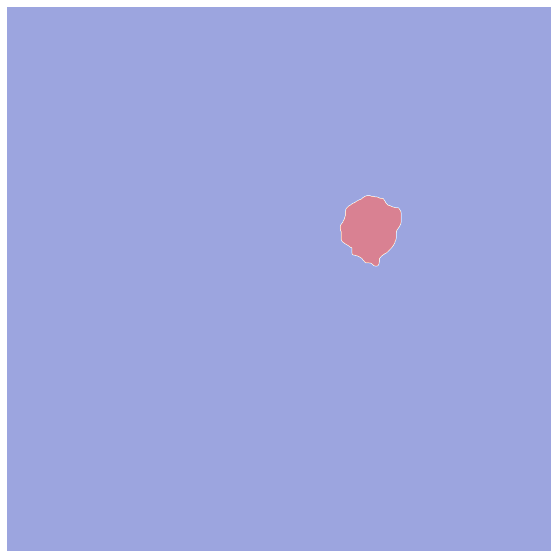

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
wandb.log({"Mask Sample 1": plt})

<h3>Combining Image with Mask</h3>

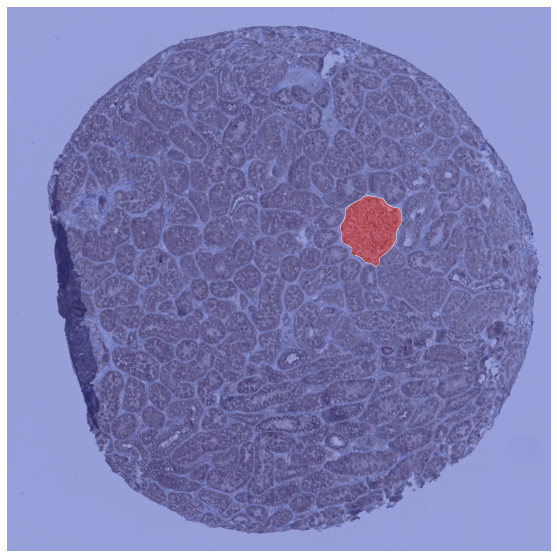

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
wandb.log({"Image with Mask Sample 1": plt})

In [9]:
image_ids = df.id
image_files = glob.glob(config.train_path + "train_images/*")


In [10]:
'''for id, img in tqdm(zip(image_ids, image_files), total=len(image_ids)):
    img = tiff.imread(img)
    mask = rle2mask(df[df["id"]==id]["rle"].iloc[-1], (img.shape[1], img.shape[0]))
    mask = np.expand_dims(mask, axis=2)
    save_img(path=f"./train_masks/{id}.jpg", x=mask, data_format="channels_last")
    
print("Finished Saving Masks")'''

'for id, img in tqdm(zip(image_ids, image_files), total=len(image_ids)):\n    img = tiff.imread(img)\n    mask = rle2mask(df[df["id"]==id]["rle"].iloc[-1], (img.shape[1], img.shape[0]))\n    mask = np.expand_dims(mask, axis=2)\n    save_img(path=f"./train_masks/{id}.jpg", x=mask, data_format="channels_last")\n    \nprint("Finished Saving Masks")'

In [11]:
mask_files = glob.glob(config.train_path + "/train_masks/*")

In [12]:
df['image'] = image_files
df['mask'] = mask_files

In [13]:
def read_and_decode(metadata):
    #print(tf.make_ndarray(metadata['fname']))
    img = tf.io.read_file(metadata['fname'])
    img = decode_tiff(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(metadata['mname'])
    
    mask = decode_jpeg(mask)
    
    #mask = tf.convert_to_tensor(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    return img, mask, metadata    

In [14]:
def resize_img_and_mask(im, mask, metadata, TARGET_WIDTH=1024):
    image_size = tf.stack([metadata['width'], metadata['height']])
    image_size = tf.cast(image_size, dtype=tf.int32)
    
    scale_factor = tf.cast(TARGET_WIDTH, tf.float32) / tf.cast(image_size[0], tf.float32)
    scale_factor = tf.math.minimum(scale_factor, 1.0)
    new_image_size = tf.stack([tf.math.round(scale_factor * tf.cast(image_size[0], tf.float32)), 
                                tf.math.round(scale_factor * tf.cast(image_size[1], tf.float32))])
    im = tf.image.resize(im, tf.stack([image_size[1], TARGET_WIDTH]), preserve_aspect_ratio=True)
    mask = tf.image.resize(mask, tf.stack([image_size[1], TARGET_WIDTH]), preserve_aspect_ratio=True)
    ID = metadata['id']
    organ = metadata['organ']
    org_id = metadata['org_id']
    age = metadata['age']
    
    return ID, im[:, :, :3], mask, image_size, organ, org_id, age


In [15]:
def org_name_to_num(df):
    label_encoder = preprocessing.LabelEncoder()
    df['org_id']= label_encoder.fit_transform(df['organ'])
    return df['org_id'].values


In [16]:
def metadataset_from_files(frame):
    values = {
        'id': frame.id.values.astype(np.int32),
        'fname': frame['image'].values,
        'mname': frame['mask'].values,
        'width': tf.convert_to_tensor(frame['img_width'].values),
        'height': tf.convert_to_tensor(frame['img_height'].values),
        'organ': frame['organ'].values,
        'org_id': tf.convert_to_tensor(org_name_to_num(frame)),
        'age': tf.convert_to_tensor(frame['age'].values.astype(np.int32))
    }
    metadataset = tf.data.Dataset.from_tensor_slices(values)
    
    return metadataset

metadataset = metadataset_from_files(df)
dataset = metadataset.map(read_and_decode, num_parallel_calls=AUTO)
dataset = dataset.map(resize_img_and_mask, num_parallel_calls=AUTO)

dataset_iterator = iter(dataset.apply(tf.data.experimental.dense_to_ragged_batch(IMAGES_PER_SHARD)))


2022-07-30 23:47:35.985483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 23:47:36.357426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 23:47:36.357608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 23:47:36.358293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
print(org_name_to_num(df)[3])

2


In [18]:
ID, img, mask, size, organ, org_id, age = next(dataset_iterator)

tf.Tensor([3 3 4 2 4 0 1 3 4 1], shape=(10,), dtype=int64)
(1024, 1024, 3)
(1024, 1024, 1)


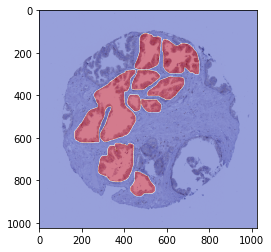

In [19]:
print(org_id)
print(img[0].numpy().shape)
print(mask[0].numpy().shape)
plt.imshow(img[0].numpy())
plt.imshow(mask[0].numpy(), cmap='coolwarm', alpha=0.5)

In [20]:
filenames_to_process = image_files.copy()
OUTPUT_DIR = "./tissue-records"
print("TFRecords output directory: {}".format(OUTPUT_DIR))
print("Image resizing target size: {}px".format(TARGET_WIDTH))
print("Number of images: {}".format(len(filenames_to_process)))
NB_SHARDS = -(-len(filenames_to_process)//IMAGES_PER_SHARD)
print(f"Output sharded into {NB_SHARDS} files with {IMAGES_PER_SHARD} images per file, {len(filenames_to_process)-(NB_SHARDS-1)*IMAGES_PER_SHARD} images in last file")


TFRecords output directory: ./tissue-records
Image resizing target size: 1024px
Number of images: 351
Output sharded into 36 files with 10 images per file, 1 images in last file


In [21]:
def compute_id_bytestring(s):
    computed_id = s
    return str(computed_id).encode('utf-8')
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value)) # WARNING: this expects a list of byte strings, not a list of bytes!

def _int_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def to_tfrecord(tfrec_filewriter, ids, img_bytes, mask_bytes, widths, heights, organs, org_ids, ages):
    feature = {
        "image/encoded": _bytes_feature([img_bytes]), #Compressed image bytes
        "image/source_id": _int_feature([ids]),    #ID
        "image/width": _int_feature([widths]),        #image width
        "image/height": _int_feature([heights]),      #image height
        "image/mask": _bytes_feature([mask_bytes]),  #compressed mask
        "image/organ": _bytes_feature([compute_id_bytestring(organs)]),      #organ name
        "image/org_id": _int_feature([org_ids]),      #organ id
        "image/age": _int_feature([ages])           #subject age
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
    
    
def recompress_jpeg(image):
    image = tf.image.convert_image_dtype(image, tf.uint8) # convert from float [0,1) to uint8 [0,255]
    return tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)


    
    

In [22]:
metadataset = metadataset_from_files(df.sample(frac=1.0, random_state=42))
dataset = metadataset.map(read_and_decode, num_parallel_calls=AUTO)
dataset = dataset.map(resize_img_and_mask, num_parallel_calls=AUTO)
dataset = dataset.map(lambda ID, img, mask, size, organ, org_id, age:
    (ID, recompress_jpeg(img), recompress_jpeg(mask), size, organ, org_id, age), 
    num_parallel_calls=AUTO)
dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(IMAGES_PER_SHARD))


In [23]:
TEST_SHARDS = [4,8,10,15,17,20,27,31]  # these files will be labeled "test" other files "train"

if os.path.isdir(OUTPUT_DIR) and len(os.listdir(OUTPUT_DIR))>0:
    print("ERROR: the output directory exists and is not empty. Aborting. Please empty the output directory manually before proceeding.")
else:
    my_dir = True
    print("QUACK!!!")
    if my_dir:
        os.mkdir(OUTPUT_DIR)
        print("Writing TFRecords...")
        for shard, (ID, img, mask, size, organ, org_id, age) in enumerate(dataset):
            shard_size = img.numpy().shape[0]
            filename = OUTPUT_NAME_PREFIX+"w{}px_{:03d}_of_{:03d}-{:03d}.{}.tfrec".format(
                TARGET_WIDTH, shard+1, NB_SHARDS, shard_size, 'test' if shard in TEST_SHARDS else 'train')
            with tf.io.TFRecordWriter(os.path.join(OUTPUT_DIR, filename)) as file:
                for i in range(shard_size):
                    binary_id = ID[i].numpy()
                    binary_image = img[i].numpy()
                    binary_mask = mask[i].numpy()
                    binary_width   = size[i].numpy()[0]
                    binary_height  = size[i].numpy()[1]
                    binary_organ = compute_id_bytestring(organ[i].numpy().decode('utf-8'))
                    binary_org_id = org_id[i].numpy()
                    binary_age = age[i].numpy()
                    
                    example = to_tfrecord(file, binary_id, binary_image, binary_mask, 
                                          binary_width, binary_height, 
                                          binary_organ, binary_org_id, binary_age)
                    file.write(example.SerializeToString())
            print("Wrote file {} containing {} records".format(filename, shard_size))
                    



QUACK!!!
Writing TFRecords...
Wrote file tissues_w1024px_001_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_002_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_003_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_004_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_005_of_036-010.test.tfrec containing 10 records
Wrote file tissues_w1024px_006_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_007_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_008_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_009_of_036-010.test.tfrec containing 10 records
Wrote file tissues_w1024px_010_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_011_of_036-010.test.tfrec containing 10 records
Wrote file tissues_w1024px_012_of_036-010.train.tfrec containing 10 records
Wrote file tissues_w1024px_013_of_036-010.train.tfrec contain

In [24]:
def read_tfrecord(example):
    feature = {
        "image/source_id": tf.io.FixedLenFeature([], tf.int64),
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/mask": tf.io.FixedLenFeature([], tf.string),
        "image/organ": tf.io.FixedLenFeature([], tf.string),
        "image/org_id": tf.io.FixedLenFeature([], tf.int64),
        "image/age": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature)
    source_id = example["image/source_id"]
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    width = example["image/width"]
    height = example["image/height"]
    mask = tf.image.decode_jpeg(example['image/mask'], channels=3)
    organ = example["image/organ"]
    org_id = example["image/org_id"]
    age = example["image/age"]
    return source_id, image, mask, width, height, organ, org_id, age

def load_tfrecord_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset
    
    
    

In [35]:
filenames = tf.io.gfile.glob(os.path.join(OUTPUT_DIR, '*.tfrec'))
dataset = load_tfrecord_dataset(filenames)
print("Dataset Loaded.")

dataset_iterator = iter(dataset.apply(tf.data.experimental.dense_to_ragged_batch(IMAGES_PER_SHARD)))

Dataset Loaded.


In [36]:
source_ids, images, masks, widths, heights, organs, org_ids, ages = next(dataset_iterator)
images = [im.numpy() for im in images]
masks = [msk.numpy() for msk in masks]

image_shapes = [tf.cast((image.shape[1], image.shape[0]), tf.float32) for image in images]
mask_shapes = [tf.cast((mask.shape[1], mask.shape[0]), tf.float32) for mask in masks]

tf.Tensor(24194, shape=(), dtype=int64)


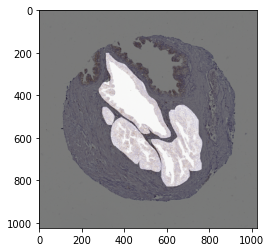

In [37]:
print(source_ids[0])
plt.imshow(images[0])
plt.imshow(masks[0], cmap='coolwarm', alpha=0.5)